CycleGAN code largely inspired by https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/CycleGAN

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    !pip3 install pickle5 -q
    !apt-get install p7zip-full -q
    !7z x 'drive/MyDrive/Colab Notebooks/Project/FreiHAND_split.7z'
    !7z x 'drive/MyDrive/Colab Notebooks/Project/RHD_published_v2.zip'
    !cp 'drive/MyDrive/Colab Notebooks/Project/Networks.py' .
    !cp 'drive/MyDrive/Colab Notebooks/Project/HandDataset.py' .
    !cp 'drive/MyDrive/Colab Notebooks/Project/Rotations.py' .
    PATH = 'drive/MyDrive/Colab Notebooks/Project/'
except:
    IN_COLAB = False
    PATH = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 256 kB 12.3 MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 484355643 bytes (462 MiB)



Break signaled

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4951331168 bytes

In [ ]:
if IN_COLAB:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

NameError: ignored

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from importlib import reload
import torch.nn.functional as F

from HandDataset import *
from Networks import *

manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
batch_size = 64
img_size = 64
nc, nz = 3, 128 # number of channels in training images
ngf, ndf = 64, 64
num_epochs = 30
lr, beta1 = 0.0002, 0.5 # hyperparam for Adam optimizers
lmbda = 10

In [ ]:
synth_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    #transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # (replace with actual mean and std)
])

real_transform = transforms.Compose([
    transforms.CenterCrop(112),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # (replace with actual mean and std)
])

synth_ds = HandDataset(
    img_dir='RHD_published_v2/training/color',
    mask_dir='RHD_published_v2/training/mask',
    anno_path='RHD_published_v2/training/anno_training.pickle',
    black_size=320,
    zfill=5,
    ext='.png',
    transform=synth_transform,
    masked=True,
    centered=True,
    coef = 2.2,
    normalise=True
)

real_ds = HandDataset(
    img_dir='FreiHAND_split/training/rgb',
    mask_dir='FreiHAND_split/training/mask',
    anno_path='FreiHAND_split/FreiHAND_anno_training.pickle', # incomplete (only contains xyz data)
    zfill=8,
    ext='.jpg',
    black_size=224,
    masked=True,
    transform=real_transform,
    normalise=False
)

In [ ]:
synth_train,synth_test = random_split(synth_ds, [len(synth_ds)-64, 64])
real_train,real_test = random_split(real_ds, [len(real_ds)-64, 64])

In [ ]:
synth_loader = DataLoader(synth_train, batch_size=batch_size, shuffle=True, drop_last=True)
real_loader = DataLoader(real_train, batch_size=batch_size, shuffle=True, drop_last=True)

synth_test_loader = DataLoader(synth_test, batch_size=batch_size, shuffle=True, drop_last=True)
real_test_loader = DataLoader(real_test, batch_size=batch_size, shuffle=True, drop_last=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
G_s2r = CycleGenerator(num_residuals=4).to(device)
G_s2r.apply(weights_init)

CycleGenerator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
  )
  (res_blocks): Sequential(
    (0): Resid

In [ ]:
G_r2s = CycleGenerator(num_residuals=4).to(device)
G_r2s.apply(weights_init)

CycleGenerator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
  )
  (res_blocks): Sequential(
    (0): Resid

In [ ]:
D_real = PatchDiscriminator(ndf=ndf).to(device)
D_real.apply(weights_init)

PatchDiscriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
  (bn2): InstanceNorm2d(128, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
  (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn_fc): BatchNorm1d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (FC1): Linear(in_features=16384, out_features=512, bias=False)
  (FC2): Linear(in_features=512, out_features=66, bias=True)
  (activ): LeakyReLU(negative_slope=

In [ ]:
D_synth = PatchDiscriminator(ndf=ndf).to(device)
D_synth.apply(weights_init)

PatchDiscriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
  (bn2): InstanceNorm2d(128, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
  (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn_fc): BatchNorm1d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (FC1): Linear(in_features=16384, out_features=512, bias=False)
  (FC2): Linear(in_features=512, out_features=66, bias=True)
  (activ): LeakyReLU(negative_slope=

In [ ]:
opt_D = optim.Adam(
    list(D_real.parameters()) + list(D_synth.parameters()),
    lr=lr,
    betas=(0.5,0.999)
)

opt_G = optim.Adam(
    list(G_s2r.parameters()) + list(G_r2s.parameters()),
    lr=lr,
    betas=(0.5,0.999)
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

In [ ]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

epoch = 0
iters = 0

In [ ]:
class ReplayBuffer:
    """https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cyclegan/utils.py"""
    def __init__(self, max_size=256):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

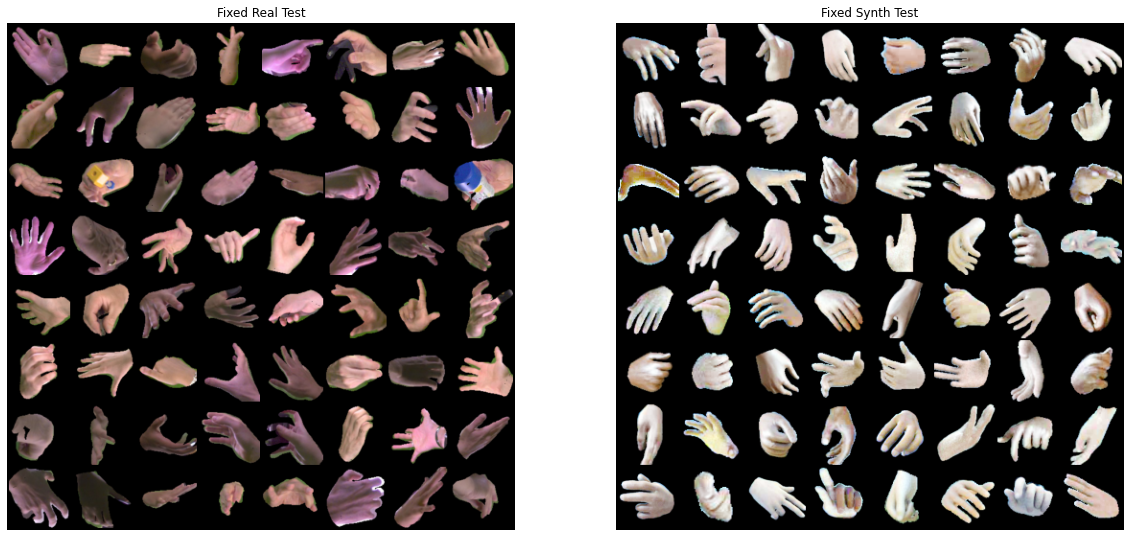

In [ ]:
fixed_real = next(iter(real_test_loader))[0][:64].to(device)
fixed_synth = next(iter(synth_test_loader))[0][:64].to(device)

plt.figure(figsize=(20,40))
ax = plt.subplot(2,2,1)
plt.axis('off')
plt.title('Fixed Real Test')
plt.imshow(np.transpose(vutils.make_grid(fixed_real[:64],
                                        padding=2, normalize=True).cpu(),(1,2,0)))

ax = plt.subplot(2,2,2)
plt.axis('off')
plt.title('Fixed Synth Test')
plt.imshow(np.transpose(vutils.make_grid(fixed_synth[:64],
                                        padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
fake_real_buffer = ReplayBuffer()
fake_synth_buffer = ReplayBuffer()

G_losses = []
D_losses = []

In [ ]:
print("Starting Training Loop...")

while epoch < num_epochs:
    synth_loader_iterator = iter(synth_loader)
    for i, real_batch in enumerate(real_loader):
        try:
            synth_batch = next(synth_loader_iterator)
        except StopIteration:
            synth_loader_iterator = iter(synth_loader)
            synth_batch = next(synth_loader_iterator)

        real = real_batch[0].to(device)
        synth = synth_batch[0].to(device)

        # Train discriminators
        with torch.cuda.amp.autocast():
            new_real_hat = G_s2r(synth)
            real_hat = fake_real_buffer.push_and_pop(new_real_hat)
            # addToBuffer(fake_real_buffer, new_real_hat)

            # if torch.count_nonzero(fake_real_buffer[-1]) == 0: # if buffer isnt filled
            #     real_hat = new_real_hat
            # else:
            #     history = getFromBuffer(fake_real_buffer, batch_size//2)
            #     new = new_real_hat[perm_cpu(batch_size, batch_size//2)]
            #     real_hat = torch.cat((history,new), 0)

            D_R_real = D_real(real)[0]
            D_R_fake = D_real(real_hat.detach())[0]
            D_R_real_loss = mse(D_R_real, torch.ones_like(D_R_real))
            D_R_fake_loss = mse(D_R_fake, torch.zeros_like(D_R_fake))
            D_R_loss = D_R_real_loss + D_R_fake_loss

            new_synth_hat = G_r2s(real)
            synth_hat = fake_synth_buffer.push_and_pop(new_synth_hat)
            # addToBuffer(fake_synth_buffer, new_synth_hat)

            # if torch.count_nonzero(fake_synth_buffer[-1]) == 0:
            #     synth_hat = new_synth_hat
            # else:
            #     history = getFromBuffer(fake_synth_buffer, batch_size//2)
            #     new = new_synth_hat[perm_cpu(batch_size, batch_size//2)]
            #     synth_hat = torch.cat((history,new), 0)
            # synth_hat = new_synth_hat
            
            D_S_real = D_synth(synth)[0]
            D_S_fake = D_synth(synth_hat.detach())[0]
            D_S_real_loss = mse(D_S_real, torch.ones_like(D_S_real))
            D_S_fake_loss = mse(D_S_fake, torch.zeros_like(D_S_fake))
            D_S_loss = D_S_real_loss + D_S_fake_loss

            D_loss = (D_R_loss + D_S_loss)/2

        opt_D.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_D)
        d_scaler.update()

        # Train generators
        with torch.cuda.amp.autocast():
            D_R_fake = D_real(real_hat)[0]
            D_S_fake = D_synth(synth_hat)[0]
            loss_G_s2r = mse(D_R_fake, torch.ones_like(D_R_fake))
            loss_G_r2s = mse(D_S_fake, torch.ones_like(D_S_fake))

            #cycle loss
            cycle_synth = G_r2s(real_hat)
            cycle_real = G_s2r(synth_hat)
            cycle_synth_loss = L1(synth, cycle_synth)
            cycle_real_loss = L1(real, cycle_real)

            G_loss = (
                loss_G_s2r
                + loss_G_r2s
                + cycle_synth_loss * lmbda
                + cycle_real_loss * lmbda
            )

        opt_G.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_G)
        g_scaler.update()

        if iters % 50 == 0:
            D_losses.append(D_loss.item())
            G_losses.append(G_loss.item())
            print('[%d][%d/%d]\tLoss_D: %.3f\tLoss_G: %.3f'
                % (epoch, i, len(real_loader),
                    D_loss.item(), G_loss.item()))
            
        if iters % 500 == 0:
            with torch.no_grad():
                plt.figure(figsize=(40,40))

                real_hat = G_s2r(fixed_synth)
                #img_list_synth2real.append(vutils.make_grid(real_hat, padding=2, normalize=True))
                ax = plt.subplot(2,2,1)
                plt.axis('off')
                plt.title('Synth to Real')
                plt.imshow(np.transpose(vutils.make_grid(real_hat[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))

                synth_hat_hat = G_r2s(real_hat)
                #img_list_real2synth.append(vutils.make_grid(x_hat, padding=2, normalize=True))
                ax = plt.subplot(2,2,2)
                plt.axis('off')
                plt.title('Real back to synth')
                plt.imshow(np.transpose(vutils.make_grid(synth_hat_hat[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))
                
                synth_hat = G_r2s(fixed_real)
                #img_list_synth2real.append(vutils.make_grid(real_hat, padding=2, normalize=True))
                ax = plt.subplot(2,2,3)
                plt.axis('off')
                plt.title('Real to synth')
                plt.imshow(np.transpose(vutils.make_grid(synth_hat[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))

                real_hat_hat = G_s2r(synth_hat)
                #img_list_real2synth.append(vutils.make_grid(x_hat, padding=2, normalize=True))
                ax = plt.subplot(2,2,4)
                plt.axis('off')
                plt.title('Synth back to real')
                plt.imshow(np.transpose(vutils.make_grid(real_hat_hat[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))
                plt.pause(0.01)

        iters += 1
    epoch += 1

Output hidden; open in https://colab.research.google.com to view.

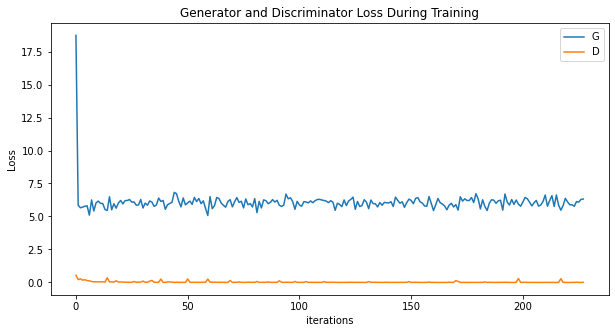

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(D_real.state_dict(), PATH+'models/cyclegan_auth/D_real_27_11_21_epoch_{}.pth'.format(epoch))
torch.save(G_s2r.state_dict(), PATH+'models/cyclegan_auth/G_s2r_27_11_21_epoch_{}.pth'.format(epoch))